In [1]:
import pandas as pd

In [16]:
# Define the column types to optimize memory usage
dtype_dict = {
    'overall': 'int16',
    'movement_agility': 'float32',
    'skill_ball_control': 'float32',
    'power_strength': 'float32',
    'potential': 'int16',
    'age': 'int16',
    'pace': 'float32',
    'shooting': 'float32',
    
}

# Define the columns to load
use_cols = ['player_id', 'fifa_version', 'overall', 'movement_agility', 'skill_ball_control', 'power_strength', 'potential', 'age', 'pace', 'shooting']

# Initialize an empty list to hold chunks
chunk_list = []

# Define the chunk size
chunk_size = 50000  # Adjust this according to your system's memory

# Process the CSV in chunks
for chunk in pd.read_csv('fifa_data.csv', usecols=use_cols, dtype=dtype_dict, chunksize=chunk_size):
    # Filter out the top n% of players in this chunk
    top_n_threshold = chunk['overall'].quantile(1 - 0.05)
    filtered_chunk = chunk[chunk['overall'] >= top_n_threshold]
    chunk_list.append(filtered_chunk)

# Concatenate the filtered chunks into one DataFrame
top_players = pd.concat(chunk_list)

In [11]:
# Group by 'fifa_version' and calculate the mean of the attribute
agility_trend = top_players.groupby('fifa_version')['movement_agility'].mean()
ball_control_trend = top_players.groupby('fifa_version')['skill_ball_control'].mean()
strength_trend = top_players.groupby('fifa_version')['power_strength'].mean()

# Now you can use these trends to plot graphs or further analyze.

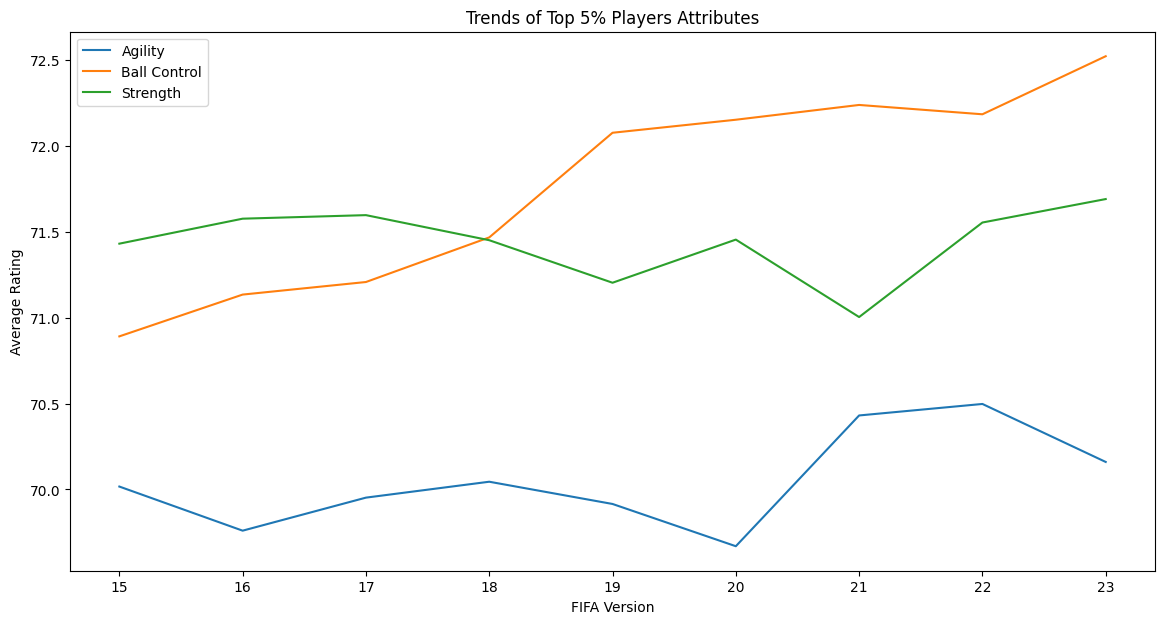

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(agility_trend.index, agility_trend.values, label='Agility')
plt.plot(ball_control_trend.index, ball_control_trend.values, label='Ball Control')
plt.plot(strength_trend.index, strength_trend.values, label='Strength')
plt.legend()
plt.xlabel('FIFA Version')
plt.ylabel('Average Rating')
plt.title('Trends of Top 5% Players Attributes')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [24]:
# Split the DataFrame into training and testing sets
train_df = top_players[top_players['fifa_version'] <= 22]  # Data up to FIFA 22 for training
test_df = top_players[top_players['fifa_version'] == 23]   # Data for FIFA 23 for testing

In [25]:
# Define your features and target
features = ['age', 'overall', 'pace', 'shooting']  # example feature columns
target = 'potential'  # the target column

# Separate features and target for both training and testing data
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [26]:
from sklearn.impute import SimpleImputer

# Handle NaN values using imputation
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [27]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Make predictions and evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.3943766011317824


In [31]:
# Step 1: Select FIFA 23 data
fifa_23_data = top_players[top_players['fifa_version'] == 23]

# Step 2: Handle missing values
# Assuming you've already created an imputer while preparing your training data
# Use the same imputer to transform the FIFA 23 data
X_future = imputer.transform(fifa_23_data[features])

# Now X_future is your future_data, ready to be used for predictions
future_predictions = model.predict(X_future)

# Optionally, you can create a DataFrame to view the predictions alongside player IDs
predictions_df = pd.DataFrame({
    'player_id': fifa_23_data['player_id'],
    'predicted_potential': future_predictions
})

# Display or export predictions_df as needed
print(predictions_df.head()) 

   player_id  predicted_potential
0     158023                91.00
1     165153                91.00
2     188545                91.00
3     192985                92.49
4     231747                95.00


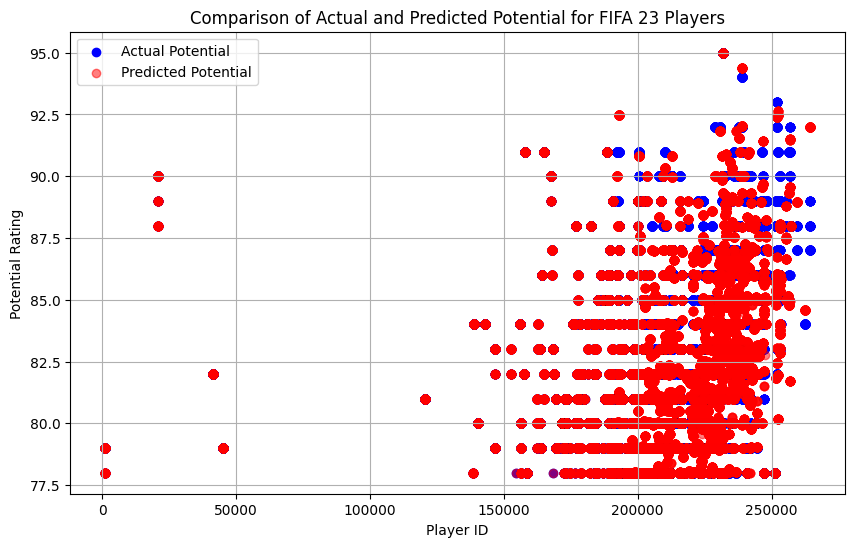

In [32]:
# Merge the actual and predicted data
comparison_df = fifa_23_data.merge(predictions_df, on='player_id')

# Create a plot
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['player_id'], comparison_df['potential'], color='blue', label='Actual Potential')
plt.scatter(comparison_df['player_id'], comparison_df['predicted_potential'], color='red', alpha=0.5, label='Predicted Potential')

# Adding titles and labels
plt.title('Comparison of Actual and Predicted Potential for FIFA 23 Players')
plt.xlabel('Player ID')
plt.ylabel('Potential Rating')
plt.legend()
plt.grid(True)
plt.show()